In [20]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', 15)

from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [3]:
data_path = r'D:\USERLOG\select_user\total'
user_set = pickle.load(open(os.path.join(data_path, 'user_set.pkl'), 'rb'))
user_vector = np.load(os.path.join(data_path, 'USERVEC.npy'))
with open(os.path.join(data_path, 'total_user_dic_10m_new.pkl'), 'rb') as f:
    user_dic = pickle.load(f)

In [13]:
n_cluster=4
km_cls = KMeans(n_clusters=n_cluster, n_jobs=4).fit(user_vector)
km_label = km_cls.labels_

user_list = [user[10:] for user in list(user_dic.keys())]
cls_df = pd.DataFrame({'ID':user_list, 'CLS':km_label})

user_cls_set = pd.merge(user_set, cls_df, how='right', on='ID')

### 군집 별 통계

In [34]:
cls_user_cnt = user_cls_set[['CLS','ID']].groupby(['CLS']).nunique()

cls_user_unique_ch = user_cls_set[['CLS','CH_match']].groupby(['CLS']).nunique()

cls_user_time_mean_df = user_cls_set[['ID','bets','CLS']].groupby(['CLS','ID']).sum().reset_index()
cls_user_time_mean = cls_user_time_mean_df[['CLS','bets']].groupby(['CLS']).mean().reset_index()

cls_user_sess_cnt_df = user_cls_set[['ID','OnOff_sess','CLS']].groupby(['CLS','ID']).count().reset_index()
cls_user_sess_cnt_mean = cls_user_sess_cnt_df[['CLS','OnOff_sess']].groupby(['CLS']).mean().reset_index()

cls_user_sess_time_mean_df = user_cls_set[['ID','OnOff_sess','CLS','bets']].groupby(['CLS','ID','OnOff_sess']).sum().reset_index()
cls_user_sess_time_mean = cls_user_sess_time_mean_df[['CLS','ID','bets']].groupby(['CLS','ID']).mean().reset_index()
cls_user_sess_time_mean_ = cls_user_sess_time_mean[['CLS','bets']].groupby(['CLS']).mean().reset_index()

cls_user_jap_df = user_cls_set[user_cls_set.CH_match == 'Jap']
cls_user_jap_ = cls_user_jap_df[['CLS','ID','CH_match','bets']].groupby(['CLS','ID']).sum().reset_index()
cls_user_jap = cls_user_jap_[['CLS','bets']].groupby(['CLS']).mean().reset_index()

# total df
cls_stat = pd.DataFrame({'Cluster':[0,1,2,3],
                         '유저 수':list(cls_user_cnt.ID),
                         '시청 채널 수':list(cls_user_unique_ch.CH_match),
                         '총 시청 시간':list(cls_user_time_mean.bets),
                         '총 세션 수':list(cls_user_sess_cnt_mean.OnOff_sess),
                         '평균 세션 지속시간':list(cls_user_sess_time_mean_.bets),
                         '평균 Jap 시간':list(cls_user_jap.bets)})

In [35]:
cls_stat

,Cluster,유저 수,시청 채널 수,총 시청 시간,총 세션 수,평균 세션 지속시간,평균 Jap 시간
0,0,9845,246,558435.458304,1857.950229,4107.576183,28307.429152
1,1,8778,243,464611.403509,1850.253475,3391.831435,27689.438369
2,2,9076,241,573422.822058,1750.902049,4323.309606,25651.823380
3,3,10322,239,593306.863883,1864.341116,4398.884852,27560.774656


### 일별 시청 시간 합계

In [14]:
by_user1 = user_cls_set[['CLS','bets','day']].groupby(['CLS','day']).sum().reset_index()
n_day = ['32(1)', '33(2)', '34(3)', '35(4)', '36(5)', '19', '20', '21', '22', '23', '24', '25', '26', '28', '29', '30', '31']
n_week = ['Sat','Sun','Mon','Tue','Wed','Sun','Mon','Tue','Wed','Thu','Fri','Sat','Sun','Tue','Wed','Thu','Fri']
by_user1['day'] = n_day * n_cluster
by_user1['week'] = n_week* n_cluster

by_user1 = by_user1.sort_values(by=['CLS','day'], axis=0)

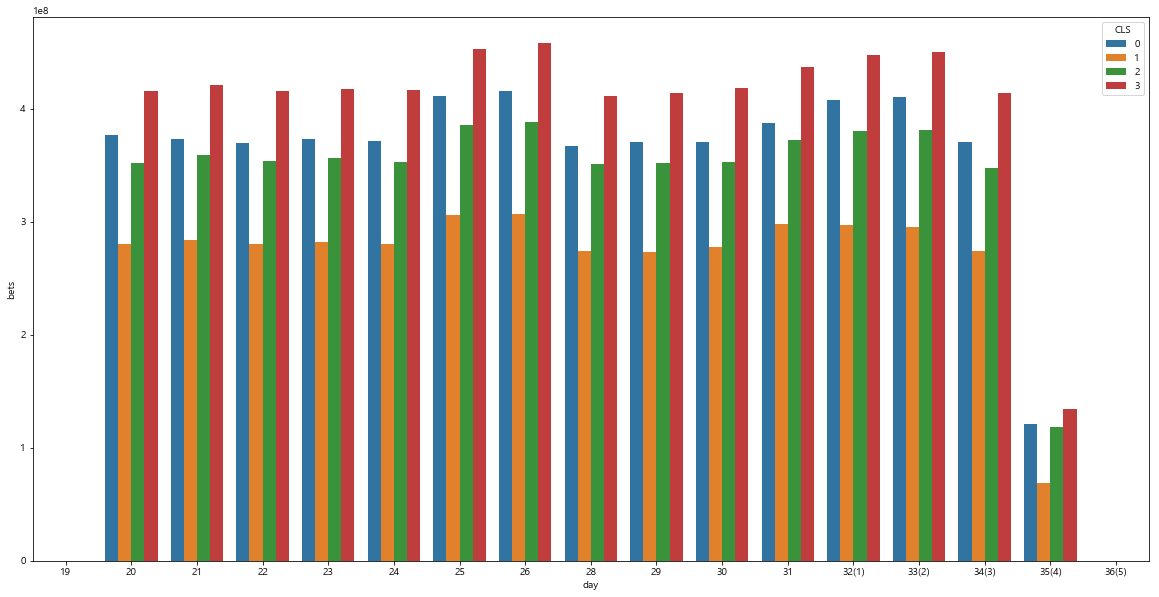

In [41]:
plt.figure(figsize=(20,10))
sns.barplot(x='day', y='bets', hue='CLS', data=by_user1)

### 일별 세션 수

In [17]:
by_user2 = user_cls_set[['CLS','OnOff_sess','day']].groupby(['CLS','day']).count().reset_index()
n_day = ['32(1)', '33(2)', '34(3)', '35(4)', '36(5)', '19', '20', '21', '22', '23', '24', '25', '26', '28', '29', '30', '31']
n_week = ['Sat','Sun','Mon','Tue','Wed','Sun','Mon','Tue','Wed','Thu','Fri','Sat','Sun','Tue','Wed','Thu','Fri']
by_user2['day'] = n_day * n_cluster
by_user2['week'] = n_week* n_cluster

by_user2 = by_user2.sort_values(by=['CLS','day'], axis=0)

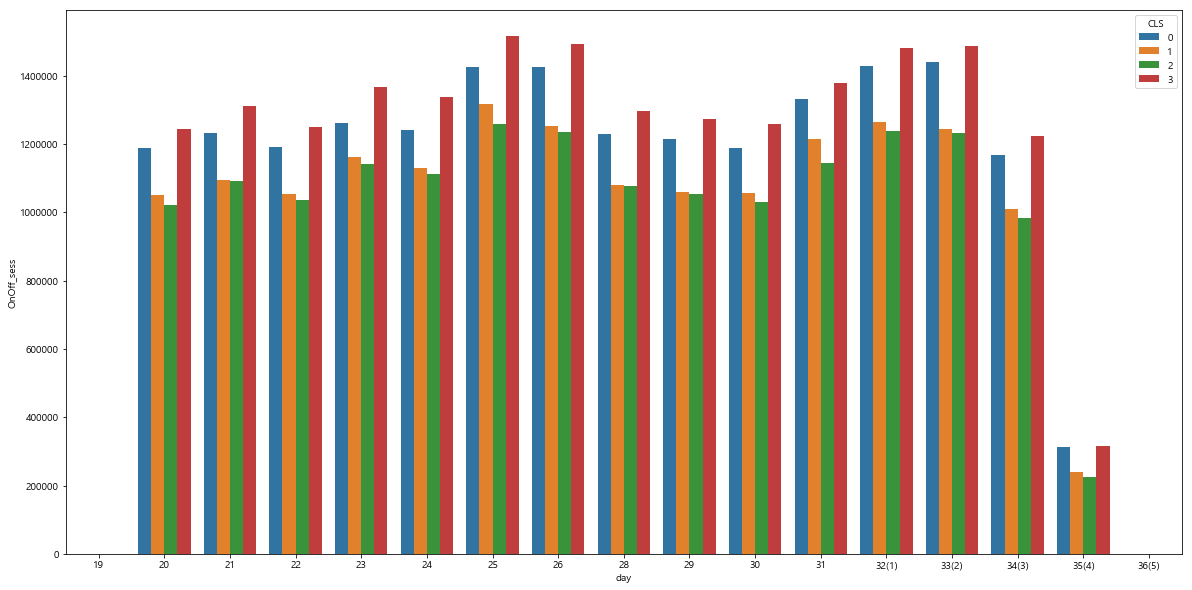

In [40]:
plt.figure(figsize=(20,10))
sns.barplot(x='day', y='OnOff_sess', hue='CLS', data=by_user2)

### 상위 시청 시간 채널

In [30]:
by_user3 = user_cls_set[['CLS','bets','category']].groupby(['CLS','category']).sum().reset_index()
#sns.barplot(x='category', y='bets', hue='CLS', data=by_user3)
by_user3 = by_user3.sort_values(by=['CLS','bets'], axis=0, ascending=False)

result3 = pd.concat([by_user3[by_user3.CLS == cls].head(10) for cls in range(n_cluster)], axis=0)

,CLS,category,bets,CLS,category,bets,CLS,category,bets,CLS,category,bets
0,0,지상파,1319991266,1,지상파,1206016820,2,지상파,1839259385,3,지상파,1969908482
1,0,연예/오락,639820593,1,종합편성,810577436,2,종합편성,1059603752,3,종합편성,1288208946
2,0,종합편성,637781486,1,뉴스/경제,482054878,2,연예/오락,444401271,3,연예/오락,577436989
3,0,영화,513853073,1,스포츠,368582817,2,뉴스/경제,366214869,3,뉴스/경제,485979387
4,0,드라마,470864552,1,Jap,243057890,2,드라마,362495328,3,드라마,469098863
5,0,스포츠,388709551,1,연예/오락,195751805,2,Jap,232815949,3,Jap,284482316
6,0,뉴스/경제,299128919,1,드라마,164790111,2,영화,211105149,3,영화,263091763
7,0,Jap,278686640,1,영화,150487469,2,스포츠,210429736,3,스포츠,233247101
8,0,어린이/만화,220185678,1,생활/레저/취미,138127054,2,생활/레저/취미,112052820,3,쇼핑,147595522
9,0,생활/레저/취미,194530900,1,쇼핑,60685100,2,쇼핑,108306208,3,생활/레저/취미,122757613


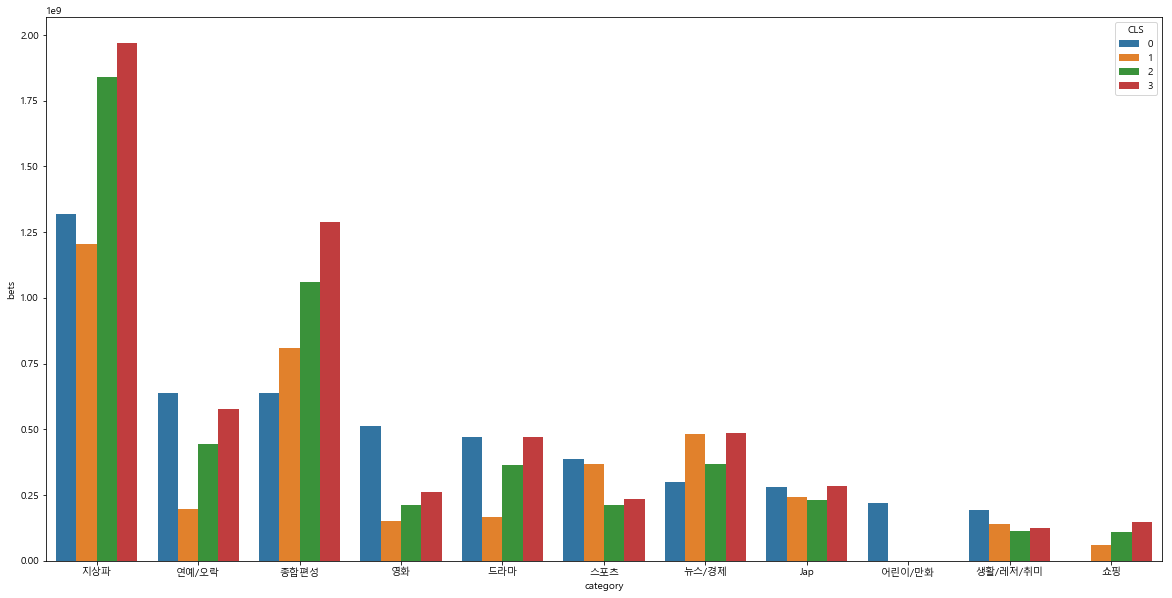

In [33]:
plt.figure(figsize=(20,10))
sns.barplot(x='category', y='bets', hue='CLS', data=result3)

result3_ = by_user3[by_user3.CLS==0].head(10)
result3_.index = range(10)
for i in range(n_cluster):
    if i == 0: continue
    df_ = by_user3[by_user3.CLS == i].head(10)
    df_.index = range(10)
    result3_ = pd.concat([result3_, df_], axis=1)
result3_

### 일별 특정 채널 시청 시간 합계

In [42]:
by_user4 = user_cls_set[['CLS','day','bets','category']].groupby(['CLS','day','category']).sum().reset_index()

#### 지상파

In [46]:
by_user4_1 = by_user4[by_user4.category == '지상파']
day_dic = {1:32,2:33,3:34,4:35,5:36}
by_user4_1['day'] = [day_dic[day] if day in list(day_dic.keys()) else day for day in list(by_user4_1.day)]
by_user4_1 = by_user4_1.sort_values(by=['CLS','day'], axis=0)

c:\users\kimlab\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


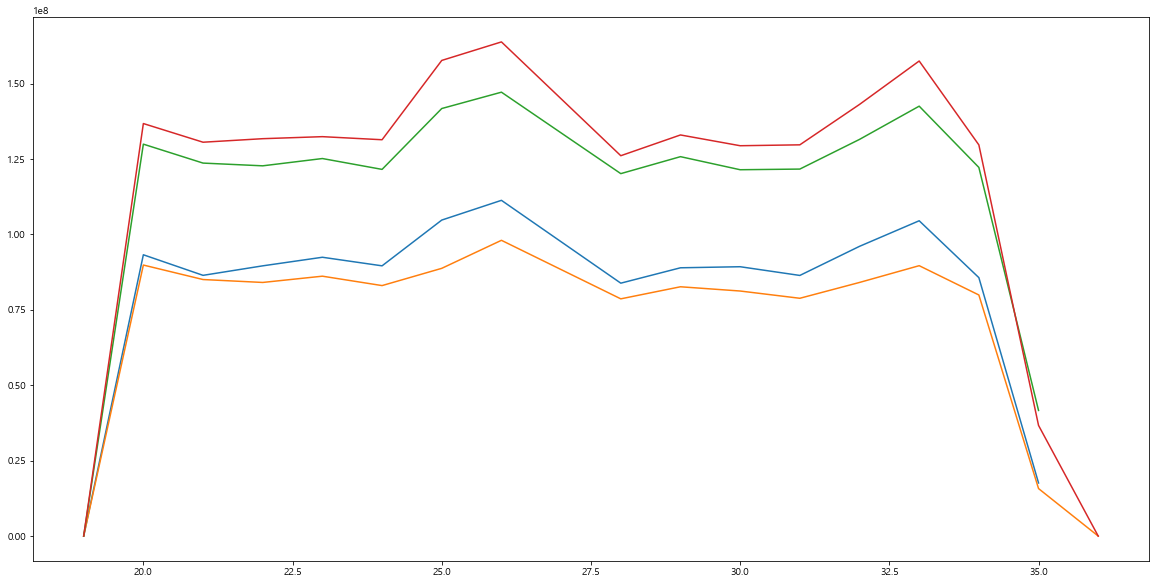

In [47]:
plt.figure(figsize=(20,10))
for cls in range(n_cluster):
    plt.plot(by_user4_1[by_user4_1.CLS==cls].day, by_user4_1[by_user4_1.CLS==cls].bets)

#### 종합편성

In [48]:
by_user4_1 = by_user4[by_user4.category == '종합편성']
day_dic = {1:32,2:33,3:34,4:35,5:36}
by_user4_1['day'] = [day_dic[day] if day in list(day_dic.keys()) else day for day in list(by_user4_1.day)]
by_user4_1 = by_user4_1.sort_values(by=['CLS','day'], axis=0)

c:\users\kimlab\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


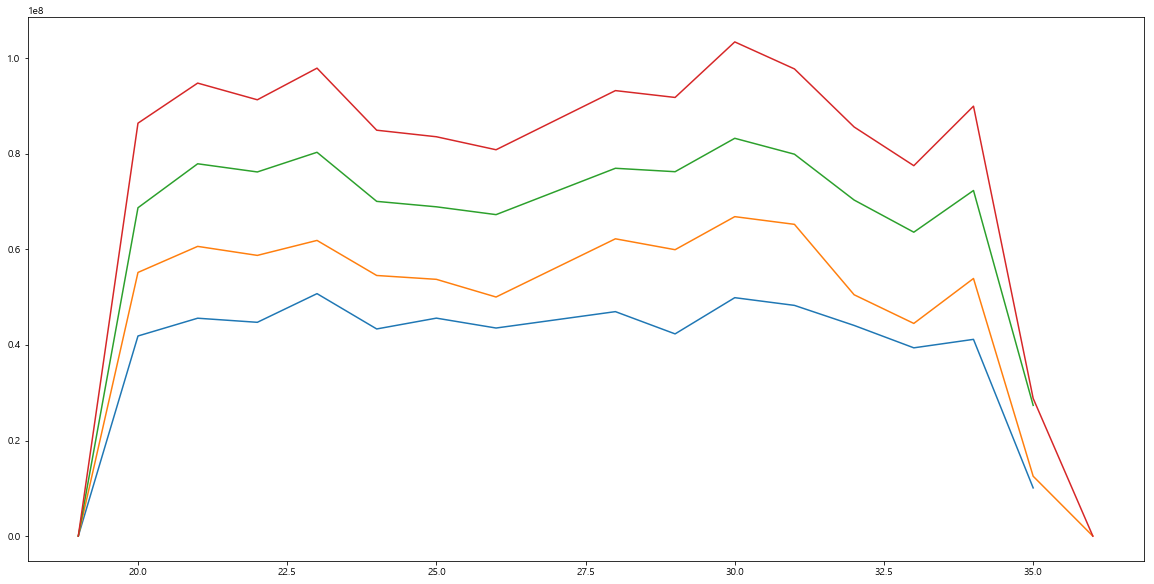

In [50]:
plt.figure(figsize=(20,10))
for cls in range(n_cluster):
    plt.plot(by_user4_1[by_user4_1.CLS==cls].day, by_user4_1[by_user4_1.CLS==cls].bets)

#### 영화

In [51]:
by_user4_1 = by_user4[by_user4.category == '영화']
day_dic = {1:32,2:33,3:34,4:35,5:36}
by_user4_1['day'] = [day_dic[day] if day in list(day_dic.keys()) else day for day in list(by_user4_1.day)]
by_user4_1 = by_user4_1.sort_values(by=['CLS','day'], axis=0)

c:\users\kimlab\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


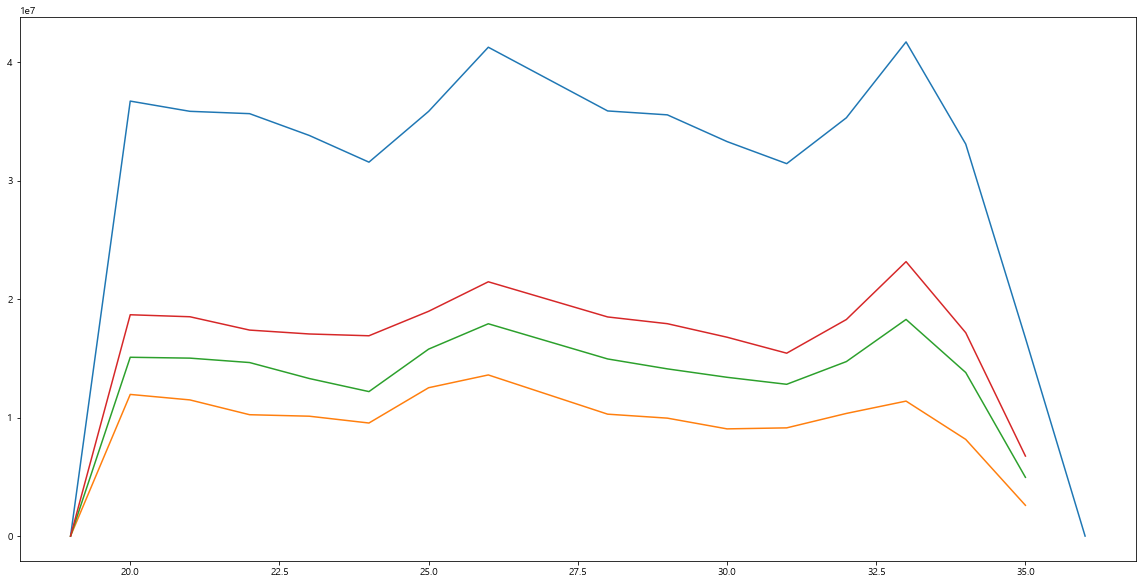

In [53]:
plt.figure(figsize=(20,10))
for cls in range(n_cluster):
    plt.plot(by_user4_1[by_user4_1.CLS==cls].day, by_user4_1[by_user4_1.CLS==cls].bets)

#### Jap

In [54]:
by_user4_1 = by_user4[by_user4.category == 'Jap']
day_dic = {1:32,2:33,3:34,4:35,5:36}
by_user4_1['day'] = [day_dic[day] if day in list(day_dic.keys()) else day for day in list(by_user4_1.day)]
by_user4_1 = by_user4_1.sort_values(by=['CLS','day'], axis=0)

c:\users\kimlab\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


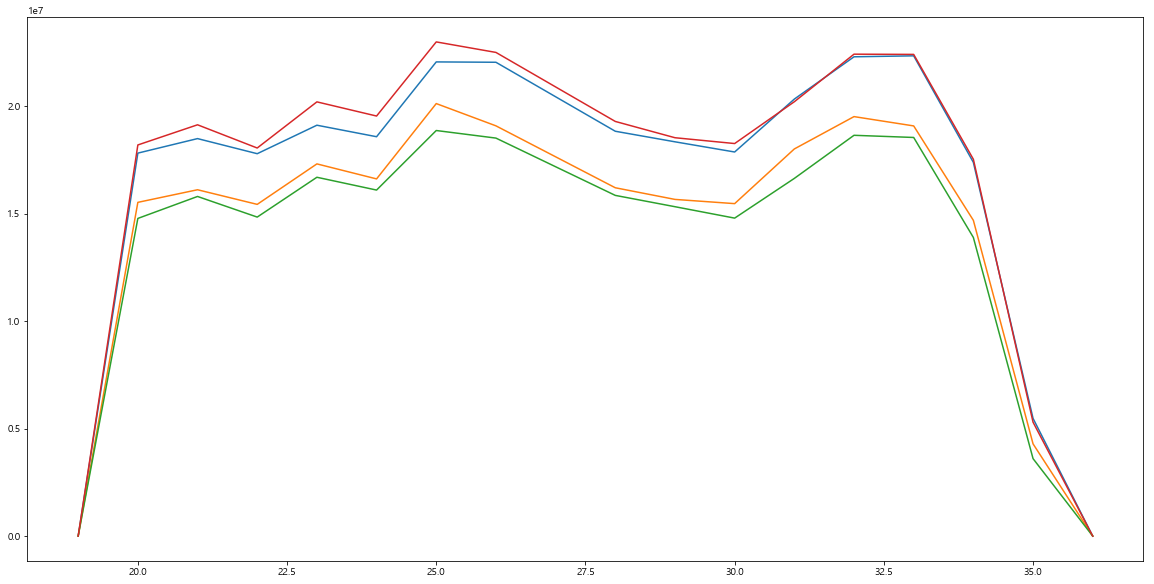

In [55]:
plt.figure(figsize=(20,10))
for cls in range(n_cluster):
    plt.plot(by_user4_1[by_user4_1.CLS==cls].day, by_user4_1[by_user4_1.CLS==cls].bets)